# Tensorflow Dataset API 활용하기
#### feat. kaggle dataset ['Dogs vs. Cats Redux: Kernels Edition'](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)  

[taki0112](https://github.com/taki0112/Tensorflow-DatasetAPI)와, [HasnainRaz](https://github.com/HasnainRaz/Tensorflow-input-pipeline/blob/master/utility.py)의 github를 참고하여 작성하였습니다.

In [1]:
import glob
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

### 1. glob 라이브러리를 사용하여 폴더 안에 이미지 파일 리스트를 저장

In [2]:
# 예제 이미지 중 10개만 샘플로 사용
# 이미지 경로를 입력한 후 폴더 안에 있는 모든 파일(*.*)을 리스트로 저장
train_images = glob.glob('./00_project/cat_n_dogs/sample/*.*')

In [3]:
# 저장된 리스트 확인
train_images

['./00_project/cat_n_dogs/sample\\cat.0.jpg',
 './00_project/cat_n_dogs/sample\\cat.1.jpg',
 './00_project/cat_n_dogs/sample\\cat.2.jpg',
 './00_project/cat_n_dogs/sample\\cat.3.jpg',
 './00_project/cat_n_dogs/sample\\cat.4.jpg',
 './00_project/cat_n_dogs/sample\\dog.12495.jpg',
 './00_project/cat_n_dogs/sample\\dog.12496.jpg',
 './00_project/cat_n_dogs/sample\\dog.12497.jpg',
 './00_project/cat_n_dogs/sample\\dog.12498.jpg',
 './00_project/cat_n_dogs/sample\\dog.12499.jpg']

### 2. 이미지 이름에 따라 라벨 다르게 붙이기

In [4]:
print(train_images[1][31:34]) # 저장한 리스트에 있는 파일이름 중 31~33번째 문자열 출력

cat


In [5]:
# 이미지 파일 이름을 처음부터 끝까지 하나씩 불러오기
# 31~33번째 문자열이 cat 이라면 0으로 놔두고, 아니라면 1을 리스트로 저장
train_labels = list(0 if labels[31:34] == 'cat' else 1 for labels in train_images)

In [6]:
# 잘 저장되었나 확인
train_labels

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

## 3. Data Augmentation

In [7]:
# image augmentation에 필요한 parameters
load_image_size = 256
image_channels = 3
crop_size = load_image_size + (30 if load_image_size == 256 else 15)

def decode_images(filename, label):
    x = tf.read_file(filename) # file read 
    x_decode = tf.image.decode_jpeg(x, channels=image_channels) # for RGB
    img = tf.image.resize_images(x_decode, [load_image_size, load_image_size])
    # img = tf.cast(img, tf.float32) / 127.5 - 1   # -1 ~ 1
    img = tf.cast(img, tf.float32) / 256           # 0 ~ 1
    
    return img, label
    
def data_aug(image, label):
    # 매번 seed 변경
    seed = random.randint(0, 2 ** 10 - 1)
    
    # flip과 crop을 random으로 수행
    random_flip = tf.cast(tf.random_uniform([], maxval=2, dtype=tf.int32), tf.bool)
    image = tf.cond(random_flip,
                    lambda: tf.image.random_flip_left_right(image, seed=seed),
                    lambda: tf.identity(image))
    ori_image_shape = tf.shape(image)
    random_crop = tf.cast(tf.random_uniform([], maxval=2, dtype=tf.int32), tf.bool)
    image = tf.cond(random_crop,
                    lambda: tf.image.resize_images(image, [crop_size, crop_size]),
                    lambda: tf.identity(image))
    image = tf.cond(random_crop,
                    lambda: tf.random_crop(image, ori_image_shape, seed=seed),
                    lambda: tf.identity(image))
    
    return image, label

## 4. make Dataset

In [8]:
# 이미지와 라벨 데이터로 Dataset 만들기
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [9]:
# Dataset으로 이미지 decoding / augmentation 나눠서 수행
train_data = train_data.map(decode_images)
train_aug_data = train_data.map(data_aug)

In [10]:
# iterator 생성
data_iterator = tf.data.Iterator.from_structure(train_aug_data.output_types, train_aug_data.output_shapes)
next_element = data_iterator.get_next()

# iterator initializer 생성
init_iter = data_iterator.make_initializer(train_aug_data)

In [11]:
# Session 생성
sess = tf.InteractiveSession()

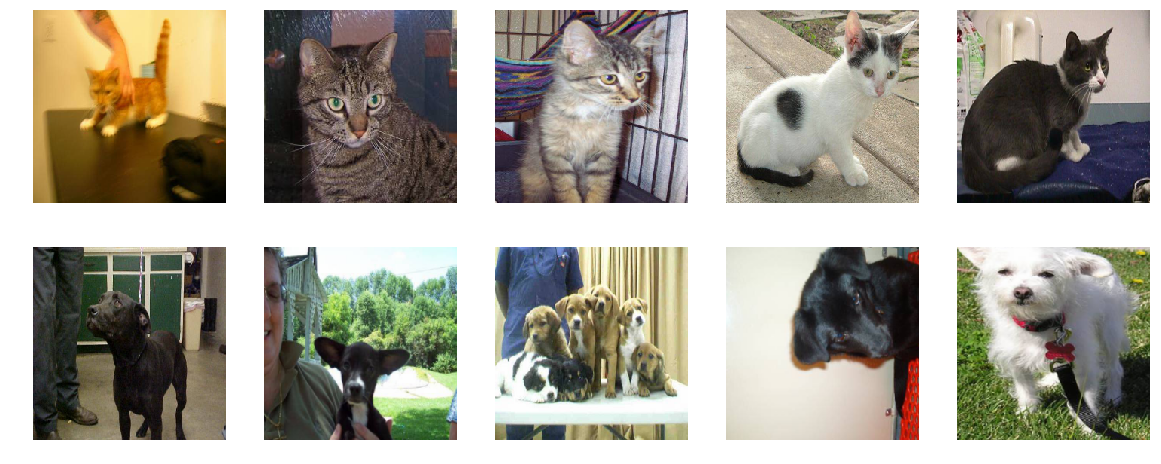

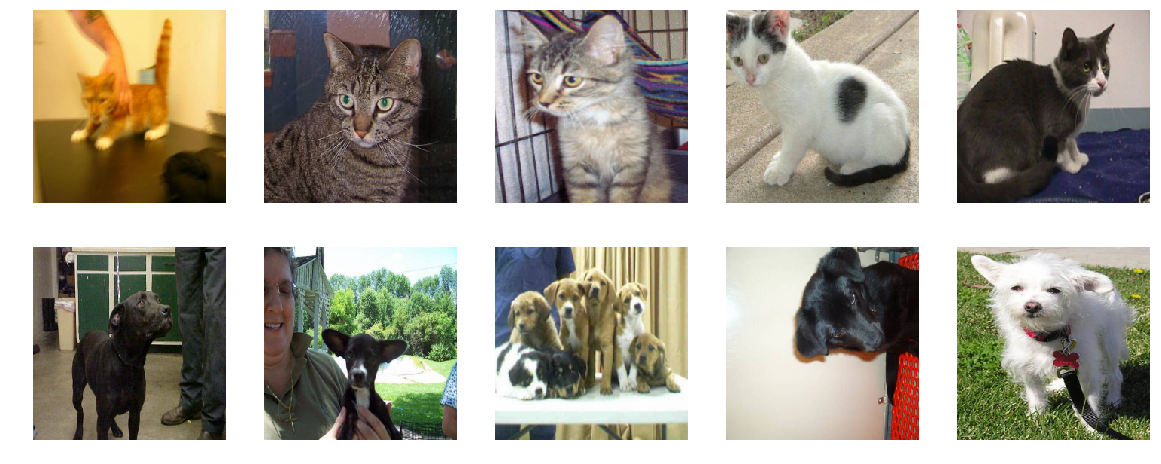

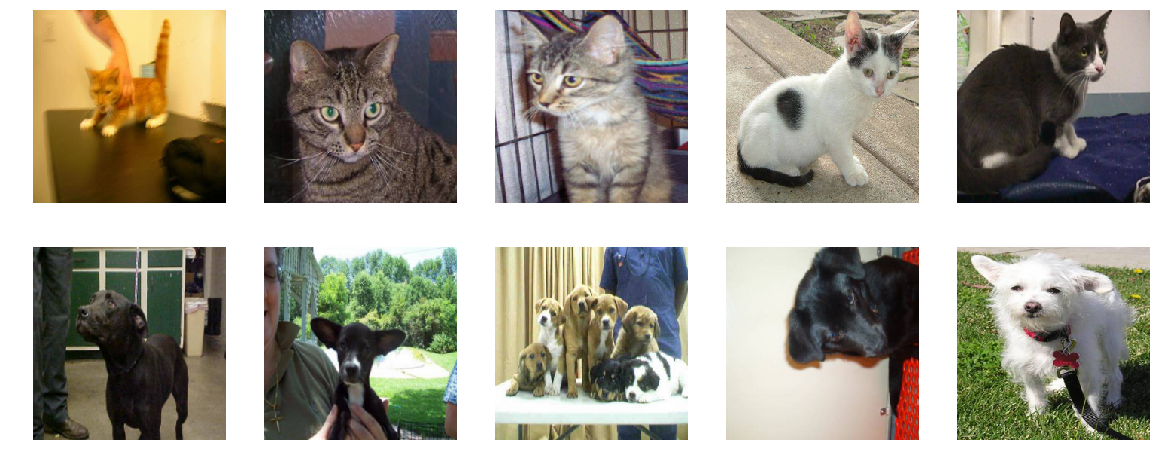

In [12]:
# 3번 반복해서 잘 되나 확인
for ii in range(3):
    # 매 epoch 마다 새로운 이미지 data 제공
    train_aug_data = lambda: train_data.map(data_aug)
    
    # 새로 들어온 데이터로 iterator initialize
    sess.run(init_iter)

    f, ax = plt.subplots(2, 5, figsize=(20,8))

    for i in range(10):
        try:
            img, labels = sess.run(next_element)
            # print(labels)
            ax[i//5, i%5].imshow(img)
            ax[i//5, i%5].axis('off')
        except:
            print("End of dataset")